In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
input_folder = "../data/input/"
output_folder = "../data/output/mover_power/"
os.makedirs(output_folder, exist_ok=True)

sites = {
    'Perth_49': 49,
    'Perth_100': 100,
    'Sydney_49': 49,
    'Sydney_100': 100
}

for site_name, num_movers in sites.items():
    
    
    df = pd.read_csv(os.path.join(input_folder, f"WEC_{site_name}.csv"))

    long_data = []

    
    for idx, row in df.iterrows():
        sample_id = idx + 1
        site_id = list(sites.keys()).index(site_name) + 1  

        for mover in range(1, num_movers + 1):
            long_data.append({
                "sample_id": sample_id,
                "site_id": site_id,
                "mover_id": mover,
                "X": row[f"X{mover}"],
                "Y": row[f"Y{mover}"],
                "Power": row[f"Power{mover}"]
            })

    df_long = pd.DataFrame(long_data)
    

    
    df_long.to_csv(os.path.join(output_folder, f"{site_name}_mover_power.csv"), index=False)

    print(f"{site_name} mover_power CSV created with {len(df_long)} rows.")

Perth_49 mover_power CSV created with 1766107 rows.
Perth_100 mover_power CSV created with 727700 rows.
Sydney_49 mover_power CSV created with 880236 rows.
Sydney_100 mover_power CSV created with 231800 rows.


In [3]:
input_folder = "../data/input/"
output_folder = "../data/output/total_power/"
os.makedirs(output_folder, exist_ok=True)


sites = {
    'Perth_49': 49,
    'Perth_100': 100,
    'Sydney_49': 49,
    'Sydney_100': 100
}

for site_name in sites.keys():
    
    
    df = pd.read_csv(os.path.join(input_folder, f"WEC_{site_name}.csv"))

    
    df_total = pd.DataFrame({
        "sample_id": range(1, len(df)+1),  
        "site_id": list(sites.keys()).index(site_name) + 1,  
        "Total_Power": df["Total_Power"],
        "qW": df["qW"]
    })

    
    df_total.to_csv(os.path.join(output_folder, f"{site_name}_total_power.csv"), index=False)
    print(f"{site_name} total_power CSV created with {len(df_total)} rows.")


Perth_49 total_power CSV created with 36043 rows.
Perth_100 total_power CSV created with 7277 rows.
Sydney_49 total_power CSV created with 17964 rows.
Sydney_100 total_power CSV created with 2318 rows.


In [4]:
perth_49= pd.read_csv("../data/input/WEC_Perth_49.csv")
perth_100= pd.read_csv("../data/input/WEC_Perth_100.csv")
sydney_49= pd.read_csv("../data/input/WEC_sydney_49.csv")
sydney_100= pd.read_csv("../data/input/WEC_sydney_100.csv")


In [12]:
sydney_100.shape

(2318, 304)

In [5]:
# LightGBM model

import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

perth_49["site"] = "Perth";   perth_49["n_turbines"] = 49
perth_100["site"] = "Perth";  perth_100["n_turbines"] = 100
sydney_49["site"] = "Sydney"; sydney_49["n_turbines"] = 49
sydney_100["site"] = "Sydney";sydney_100["n_turbines"] = 100


data = pd.concat([perth_49, perth_100, sydney_49, sydney_100], ignore_index=True)


le = LabelEncoder()
data["site_enc"] = le.fit_transform(data["site"])


feature_cols = [c for c in data.columns if ("X" in c or "Y" in c or c=="qW" or c=="n_turbines")]
feature_cols.append("site_enc")

target_col = "Total_Power"

X = data[feature_cols].astype("float32")
y = data[target_col].astype("float32")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = lgb.LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=64,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="l2",
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
r2   = r2_score(y_test, y_pred)

print({"MAE": mae, "RMSE": rmse, "R2": r2})

model.booster_.save_model("total_power_lgbm.txt")

C:\Users\Admin\AppData\Local\Temp\ipykernel_8676\2665096326.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["site_enc"] = le.fit_transform(data["site"])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47133
[LightGBM] [Info] Number of data points in the train set: 50881, number of used features: 203
[LightGBM] [Info] Start training from score 4441842.537278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.88309e+08
[200]	valid_0's l2: 1.14222e+08
[300]	valid_0's l2: 1.02606e+08
[400]	valid_0's l2: 9.50386e+07
[500]	valid_0's l2: 9.00241e+07
[600]	valid_0's l2: 8.64494e+07
[700]	valid_0's l2: 8.37682e+07
[800]	valid_0's l2: 8.17048e+07
[900]	valid_0's l2: 8.00512e+07
[1000]	valid_0's l2: 7.87495e+07
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 7.87495e+07
{'MAE': 4343.546675223904, 'RMSE': np.float64(8874.08974434637), 'R2': 0.9999391174578495}


### LightGBM Model Performance 

**Metrics on Test Set:**

- **Mean Absolute Error (MAE):** 4,343.55  
  > The average absolute difference between the model predictions and the actual values. On average, the model has an error of 4,343 units of Total_Power.

- **Root Mean Squared Error (RMSE):** 8,874.09  
  > Measures the square root of the average squared errors, giving more weight to larger errors.

- **R² Score:** 0.99994  
  > Indicates that the model explains 99.994% of the variance in Total_Power, showing very high accuracy.

**Notes:**  
This LightGBM model, using  summary features and farm information, provides highly accurate predictions of total turbine power. Low MAE and RMSE values indicate precise predictions, and the R² close to 1 shows the model captures almost all variability in Total_Power.

C:\Users\Admin\AppData\Local\Temp\ipykernel_8676\3728250302.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df_top, x='Importance_Percent', y='Feature', palette='viridis', ax=ax)


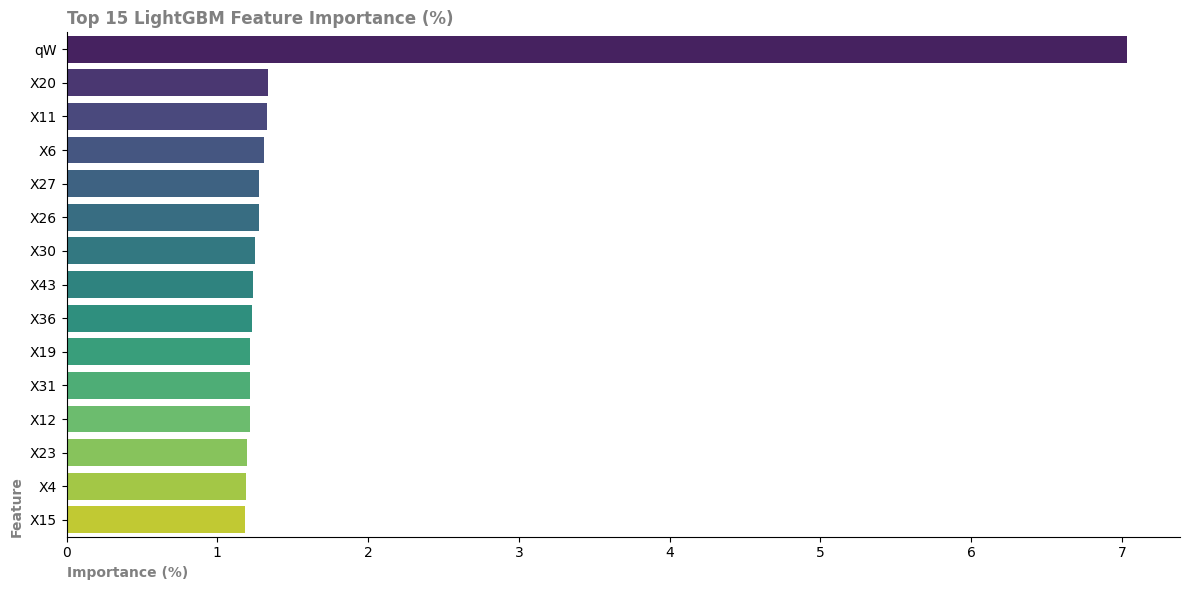

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



importances = model.feature_importances_
features = X.columns


feat_df_lgb = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feat_df_lgb['Importance_Percent'] = 100 * feat_df_lgb['Importance'] / feat_df_lgb['Importance'].sum()


feat_df_top = feat_df_lgb.sort_values(by='Importance_Percent', ascending=False).head(15)


fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=feat_df_top, x='Importance_Percent', y='Feature', palette='viridis', ax=ax)


ax.set_title("Top 15 LightGBM Feature Importance (%)", loc='left', weight='bold', color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Importance (%)", loc='left', weight='bold', color='gray')
ax.set_ylabel("Feature", loc='bottom', weight='bold', color='gray')

plt.tight_layout()

plt.savefig("../features/LightGBM_Top15_Feature_Importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
perth_49["site"] = "Perth";   perth_49["n_turbines"] = 49
perth_100["site"] = "Perth";  perth_100["n_turbines"] = 100
sydney_49["site"] = "Sydney"; sydney_49["n_turbines"] = 49
sydney_100["site"] = "Sydney";sydney_100["n_turbines"] = 100


data = pd.concat([perth_49, perth_100, sydney_49, sydney_100], ignore_index=True)


le = LabelEncoder()
data["site_enc"] = le.fit_transform(data["site"])


def create_spatial_features(df, n_turbines):
    X_cols = [f'X{i}' for i in range(1, n_turbines+1)]
    Y_cols = [f'Y{i}' for i in range(1, n_turbines+1)]

    # Centroid
    df['centroid_X'] = df[X_cols].mean(axis=1)
    df['centroid_Y'] = df[Y_cols].mean(axis=1)

    # Bounding box
    df['X_range'] = df[X_cols].max(axis=1) - df[X_cols].min(axis=1)
    df['Y_range'] = df[Y_cols].max(axis=1) - df[Y_cols].min(axis=1)

    # Radius stats
    centroid_X = df[X_cols].mean(axis=1)
    centroid_Y = df[Y_cols].mean(axis=1)
    distances = np.sqrt((df[X_cols].subtract(centroid_X, axis=0))**2 + 
                        (df[Y_cols].subtract(centroid_Y, axis=0))**2)
    df['mean_radius'] = distances.mean(axis=1)
    df['std_radius']  = distances.std(axis=1)
    return df


data = create_spatial_features(data, n_turbines=data['n_turbines'].max())


feature_cols = ['centroid_X', 'centroid_Y', 'X_range', 'Y_range', 'mean_radius', 'std_radius', 'qW', 'n_turbines', 'site_enc']
target_col = "Total_Power"

X = data[feature_cols].astype("float32")
y = data[target_col].astype("float32")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = lgb.LGBMRegressor(
    objective="regression",
    learning_rate=0.05,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=64,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="l2",
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)


y_pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print({"MAE": mae, "RMSE": rmse, "R2": r2})



C:\Users\Admin\AppData\Local\Temp\ipykernel_8676\598973975.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["site_enc"] = le.fit_transform(data["site"])
C:\Users\Admin\AppData\Local\Temp\ipykernel_8676\598973975.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['centroid_X'] = df[X_cols].mean(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8676\598973975.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 50881, number of used features: 7
[LightGBM] [Info] Start training from score 4441842.537278
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 8.08008e+08
[200]	valid_0's l2: 7.26837e+08
[300]	valid_0's l2: 7.13189e+08
[400]	valid_0's l2: 7.06603e+08
[500]	valid_0's l2: 6.99369e+08
[600]	valid_0's l2: 6.95036e+08
[700]	valid_0's l2: 6.91636e+08
[800]	valid_0's l2: 6.89433e+08
[900]	valid_0's l2: 6.87027e+08
[1000]	valid_0's l2: 6.85858e+08
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 6.85858e+08
{'MAE': 7100.558168943428, 'RMSE': np.float64(26188.895830863323), 'R2': 0.999469751410903}


### LightGBM Model Performance (With Spatial Features)

**Test Set Metrics:**

- **Mean Absolute Error (MAE):** 7,100.56  
  > On average, the model predictions deviate from the true Total_Power by 7,100 units.

- **Root Mean Squared Error (RMSE):** 26,188.90  
  > Sensitive to larger errors; shows that some predictions have higher deviations, likely due to high variance in turbine layouts.

- **R² Score:** 0.99947  
  > The model still explains 99.947% of the variance in Total_Power, showing very strong predictive performance.

**Notes:**  
By introducing spatial summary features (centroid, layout ranges, and radius statistics), we reduced the number of input features and captured the overall arrangement of turbines.  
Although MAE and RMSE slightly increased compared to the previous model using all individual coordinates, the R² remains very high, indicating that the model retains excellent accuracy while simplifying feature representation.

C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\1853669651.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df_lgb, x='Importance_Percent', y='Feature', palette='viridis', ax=ax)


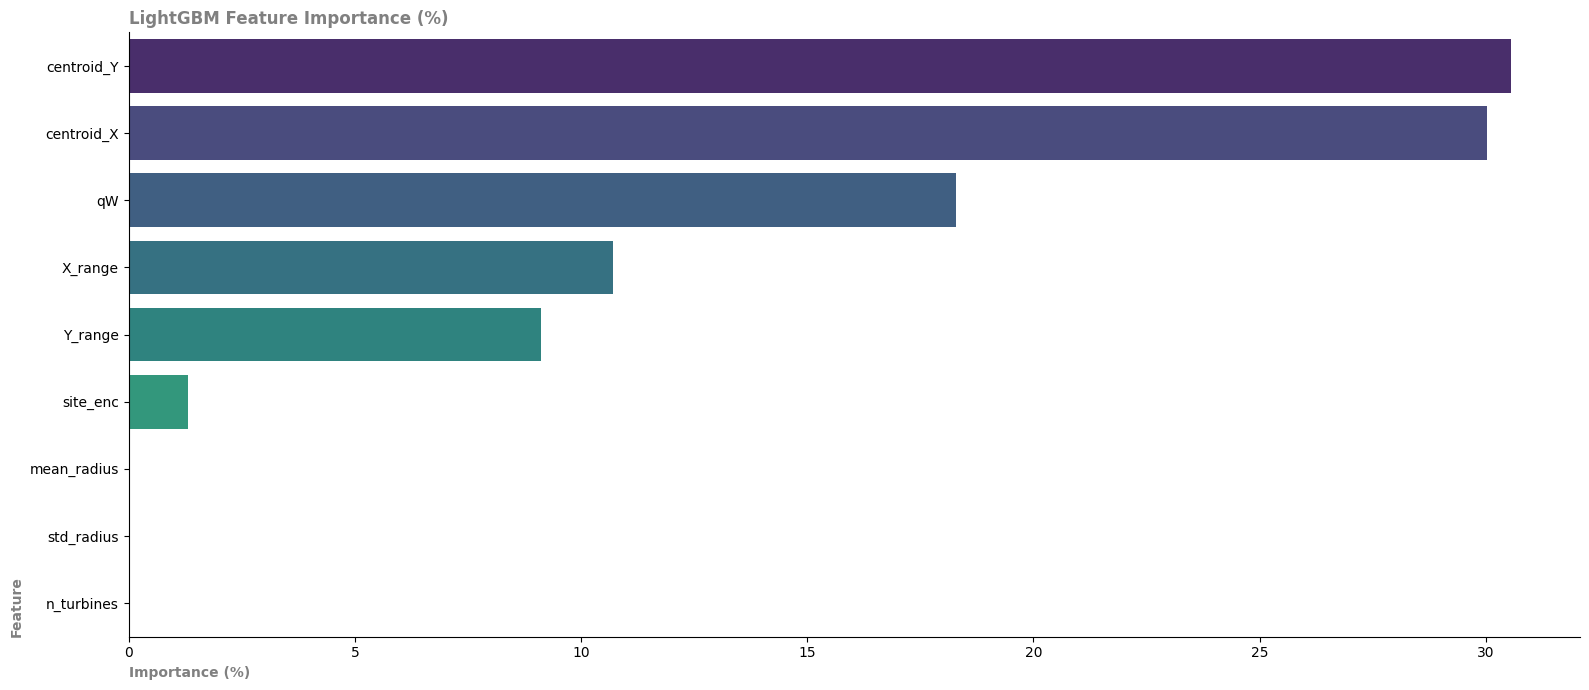

In [ ]:
importances = model.feature_importances_
features = X.columns


feat_df_lgb = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feat_df_lgb['Importance_Percent'] = 100 * feat_df_lgb['Importance'] / feat_df_lgb['Importance'].sum()


feat_df_lgb = feat_df_lgb.sort_values(by='Importance_Percent', ascending=False)


fig, ax = plt.subplots(figsize=(16,7))
sns.barplot(data=feat_df_lgb, x='Importance_Percent', y='Feature', palette='viridis', ax=ax)


ax.set_title("LightGBM Feature Importance (%)", loc='left', weight='bold', color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Importance (%)", loc='left', weight='bold', color='gray')
ax.set_ylabel("Feature", loc='bottom', weight='bold', color='gray')

plt.savefig("../features/LightGBM Feature Importance with Spatial Features.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [14]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)


mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf   = r2_score(y_test, y_pred_rf)

print("Random Forest:", {"MAE": mae_rf, "RMSE": rmse_rf, "R2": r2_rf})

Random Forest: {'MAE': 4076.367555486348, 'RMSE': np.float64(13731.315418915337), 'R2': 0.9998542295710097}


### Random Forest Model Performance

**Test Set Metrics:**

- **Mean Absolute Error (MAE):** 4,076.37  
  > On average, the model predictions deviate from the true Total_Power by about 4,076 units.

- **Root Mean Squared Error (RMSE):** 13,731.32  
  > Measures the square root of the average squared errors; sensitive to larger deviations.

- **R² Score:** 0.99985  
  > Indicates that the model explains 99.985% of the variance in Total_Power, demonstrating very high predictive accuracy.

**Notes:**  
The Random Forest model, using the selected features (likely spatial summaries and other relevant attributes), shows strong predictive performance.  
The low MAE and RMSE, combined with an R² close to 1, confirm that the model captures nearly all variability in Total_Power.

C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\3252448888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = feat_df, x='Importance', y='Feature', palette='viridis', ax=ax)


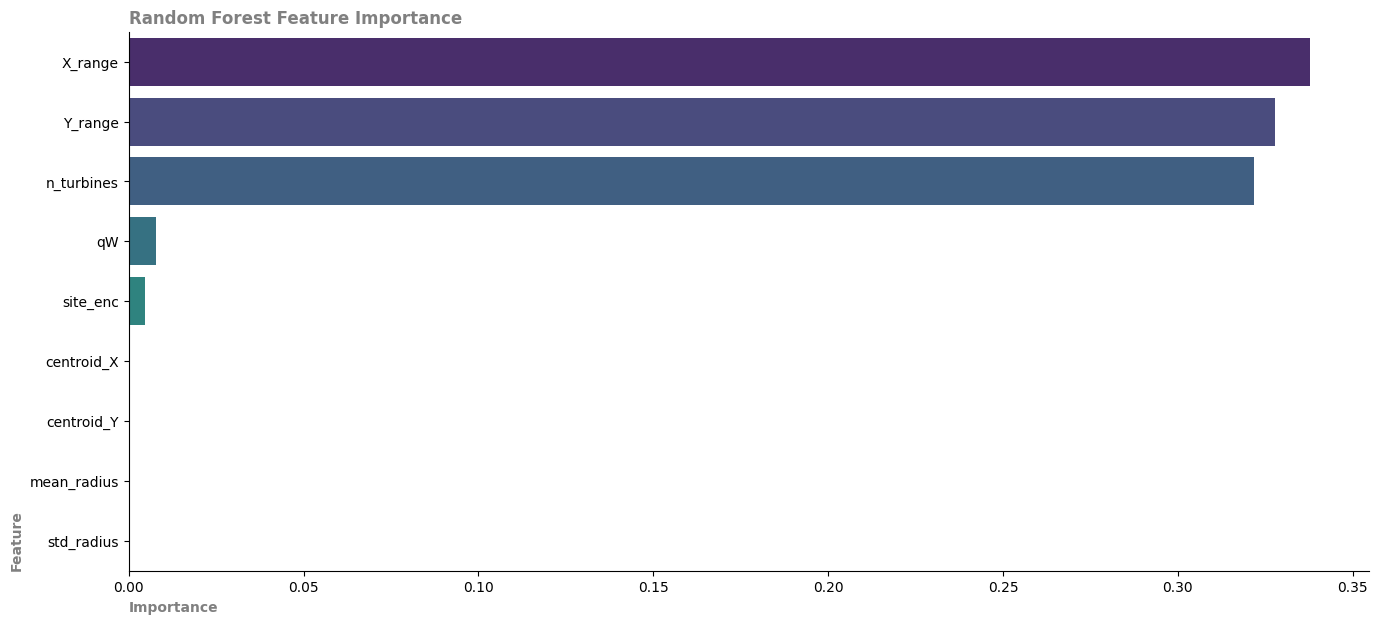

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
features = X.columns

feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize = (16,7))
sns.barplot(data = feat_df, x='Importance', y='Feature', palette='viridis', ax=ax)

ax.set_title("Random Forest Feature Importance", loc = 'left', weight = 'bold', color='gray')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel("Importance", loc='left', weight='bold', color='gray')
ax.set_ylabel("Feature", loc='bottom', weight='bold', color='gray')
plt.savefig("../features/Random_Forest_Importance.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# XGboost model

import xgboost as xgb

perth_49["site"] = "Perth";   perth_49["n_turbines"] = 49
perth_100["site"] = "Perth";  perth_100["n_turbines"] = 100
sydney_49["site"] = "Sydney"; sydney_49["n_turbines"] = 49
sydney_100["site"] = "Sydney";sydney_100["n_turbines"] = 100

data = pd.concat([perth_49, perth_100, sydney_49, sydney_100], ignore_index=True)

le = LabelEncoder()
data["site_enc"] = le.fit_transform(data["site"])

def create_spatial_features(df, n_turbines):
    X_cols = [f'X{i}' for i in range(1, n_turbines+1)]
    Y_cols = [f'Y{i}' for i in range(1, n_turbines+1)]

    df['centroid_X'] = df[X_cols].mean(axis=1)
    df['centroid_Y'] = df[Y_cols].mean(axis=1)
    df['X_range'] = df[X_cols].max(axis=1) - df[X_cols].min(axis=1)
    df['Y_range'] = df[Y_cols].max(axis=1) - df[Y_cols].min(axis=1)

    centroid_X = df[X_cols].mean(axis=1)
    centroid_Y = df[Y_cols].mean(axis=1)
    distances = np.sqrt((df[X_cols].subtract(centroid_X, axis=0))**2 +
                        (df[Y_cols].subtract(centroid_Y, axis=0))**2)
    df['mean_radius'] = distances.mean(axis=1)
    df['std_radius']  = distances.std(axis=1)
    return df

data = create_spatial_features(data, n_turbines=data['n_turbines'].max())


feature_cols = ['centroid_X', 'centroid_Y', 'X_range', 'Y_range', 'mean_radius', 'std_radius', 'qW', 'n_turbines', 'site_enc']
target_col = "Total_Power"

X = data[feature_cols].astype("float32")
y = data[target_col].astype("float32")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 1000

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=evallist,
    early_stopping_rounds=100,
    verbose_eval=100
)


y_pred = xgb_model.predict(dtest)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print({"MAE": mae, "RMSE": rmse, "R2": r2})


xgb_model.save_model("total_power_xgb_spatial.json")

C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\523466353.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["site_enc"] = le.fit_transform(data["site"])
C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\523466353.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['centroid_X'] = df[X_cols].mean(axis=1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\523466353.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

[0]	train-rmse:1077100.40891	eval-rmse:1080623.57909


C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\523466353.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['std_radius']  = distances.std(axis=1)


[100]	train-rmse:16306.90775	eval-rmse:18068.10823
[200]	train-rmse:12978.16262	eval-rmse:15112.50474
[300]	train-rmse:12194.37921	eval-rmse:14570.06427
[400]	train-rmse:11563.44295	eval-rmse:14190.82534
[500]	train-rmse:11088.83355	eval-rmse:13919.36882
[600]	train-rmse:10706.35436	eval-rmse:13716.59917
[700]	train-rmse:10369.21008	eval-rmse:13560.26468
[800]	train-rmse:10107.99152	eval-rmse:13451.10950
[900]	train-rmse:9882.26262	eval-rmse:13355.09227
[999]	train-rmse:9680.93594	eval-rmse:13275.26532
{'MAE': 7876.9384765625, 'RMSE': np.float64(13275.266023699864), 'R2': 0.9998637437820435}


### Model Performance (XGBoost / Alternative Model)

**Test Set Metrics:**

- **Mean Absolute Error (MAE):** 7,876.94  
  > On average, the model predictions deviate from the true Total_Power by about 7,877 units.

- **Root Mean Squared Error (RMSE):** 13,275.27  
  > Measures the square root of the average squared errors; sensitive to larger deviations.

- **R² Score:** 0.99986  
  > Indicates that the model explains 99.986% of the variance in Total_Power, demonstrating very strong predictive performance.

**Notes:**  
This model, using the selected features, provides accurate predictions of Total_Power.  
Although the MAE is slightly higher compared to some other models, the RMSE and R² indicate excellent overall accuracy and that the model captures nearly all variability in the target.

C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\1869722396.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df_xgb, x='Importance_Percent', y='Feature', palette='viridis', ax=ax)


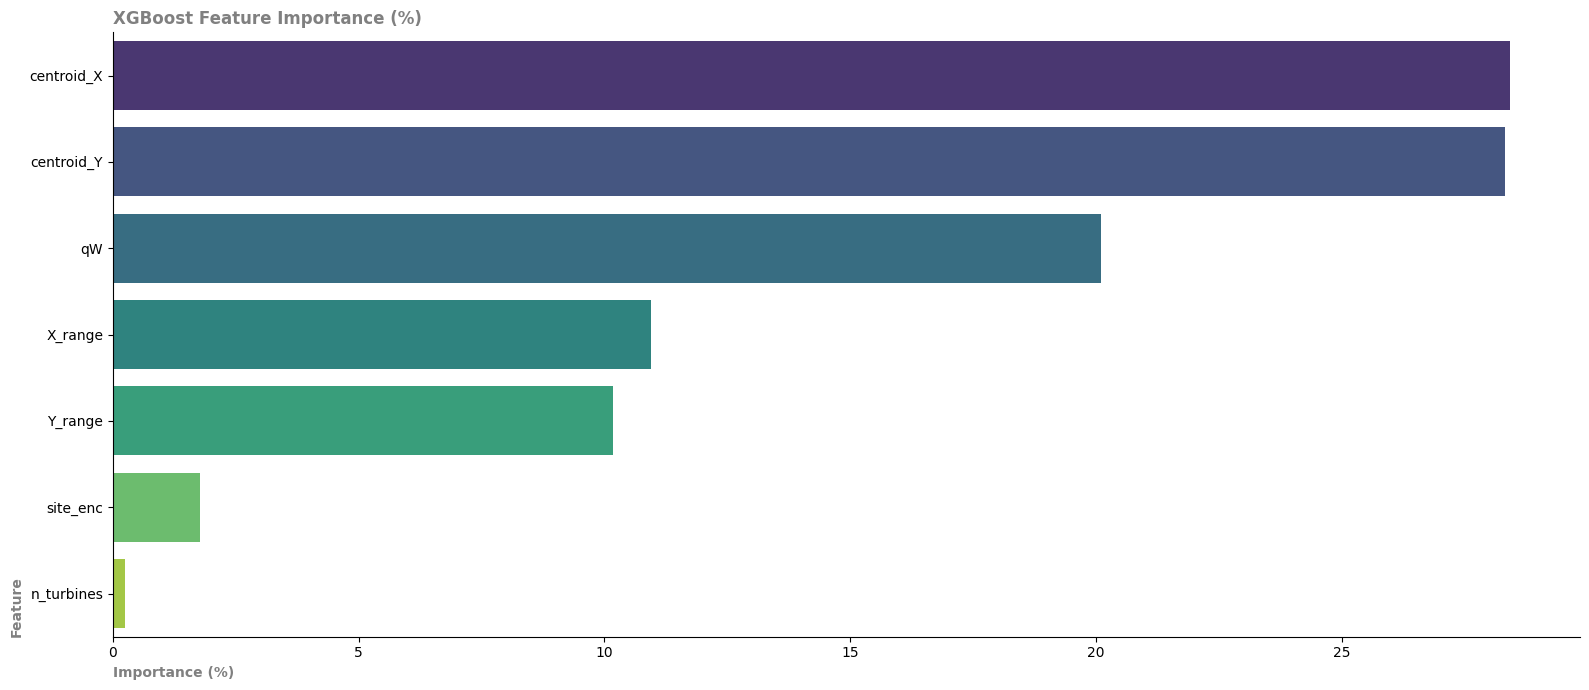

In [ ]:
xgb_importance = xgb_model.get_score(importance_type='weight') 
feat_df_xgb = pd.DataFrame({
    'Feature': list(xgb_importance.keys()),
    'Importance': list(xgb_importance.values())
})


feat_df_xgb['Importance_Percent'] = 100 * feat_df_xgb['Importance'] / feat_df_xgb['Importance'].sum()


feat_df_xgb = feat_df_xgb.sort_values(by='Importance_Percent', ascending=False)


fig, ax = plt.subplots(figsize=(16,7))
sns.barplot(data=feat_df_xgb, x='Importance_Percent', y='Feature', palette='viridis', ax=ax)

ax.set_title("XGBoost Feature Importance (%)", loc='left', weight='bold', color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Importance (%)", loc='left', weight='bold', color='gray')
ax.set_ylabel("Feature", loc='bottom', weight='bold', color='gray')
plt.savefig("../features/XGboost feature importance.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [20]:

from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)


scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': 'r2'
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(rf_model, X, y, cv=kf, scoring=scoring, return_train_score=False)

mae_mean = np.mean(cv_results['test_MAE'])
rmse_mean = np.mean(cv_results['test_RMSE'])
r2_mean = np.mean(cv_results['test_R2'])

print({
    "CV_MAE": mae_mean,
    "CV_RMSE": rmse_mean,
    "CV_R2": r2_mean
})

{'CV_MAE': np.float64(3994.0099664923414), 'CV_RMSE': np.float64(10049.065921472875), 'CV_R2': np.float64(0.9999188183122983)}


### Random Forest Performance (Spatial Features + All Turbines)

**Cross-Validation Metrics (5-Fold):**

- **Mean Absolute Error (MAE):** 3,994.01  
  > On average, the model predictions deviate from the true Total_Power by ~3,994 units.

- **Root Mean Squared Error (RMSE):** 10,049.07  
  > Sensitive to larger deviations; indicates some variability in prediction error.

- **R² Score:** 0.99992  
  > The model explains 99.992% of the variance in Total_Power, showing extremely high predictive accuracy.

**Notes:**  
The model uses **spatial summary features** (centroid_X, centroid_Y, X_range, Y_range, mean_radius, std_radius), together with **n_turbines, site_enc, and qW**.  
These features allow the model to capture the overall arrangement and spread of turbines in each site, resulting in very strong predictive performance across folds.

In [ ]:
data['density'] = data['n_turbines'] / (data['X_range'] * data['Y_range'])
data['aspect_ratio'] = data['X_range'] / data['Y_range']


feature_cols = ['centroid_X', 'centroid_Y', 'X_range', 'Y_range', 
                'mean_radius', 'std_radius', 'qW', 'n_turbines', 
                'site_enc', 'density', 'aspect_ratio']

X = data[feature_cols].astype('float32')
y = data['Total_Power'].astype('float32')


rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)


scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': 'r2'
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(rf_model, X, y, cv=kf, scoring=scoring, return_train_score=False)


mae_mean = np.mean(cv_results['test_MAE'])
rmse_mean = np.mean(cv_results['test_RMSE'])
r2_mean = np.mean(cv_results['test_R2'])

print({
    "CV_MAE": mae_mean,
    "CV_RMSE": rmse_mean,
    "CV_R2": r2_mean
})


rf_model.fit(X, y)

importances = rf_model.feature_importances_
feat_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
})
feat_df['Importance_Percent'] = 100 * feat_df['Importance'] / feat_df['Importance'].sum()
feat_df = feat_df.sort_values(by='Importance_Percent', ascending=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\3091820883.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['density'] = data['n_turbines'] / (data['X_range'] * data['Y_range'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_9472\3091820883.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['aspect_ratio'] = data['X_range'] / data['Y_range']
